In [71]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
sx = qt.sigmax();sy = qt.sigmay(); sz = qt.sigmaz(); s0 = qt.qeye(2); sm = qt.sigmam(); sp = qt.sigmap()

In [101]:


class OU_process():
    def __init__(self, sig, tc):
        self.x = sig*np.random.normal(0,1)
        self.sig = sig
        self.tc = tc
    
    def update(self, dt):
        n = np.random.normal(0,1)
        self.x = self.x*(np.exp(-dt/self.tc)) + +np.sqrt(1-np.exp(-2*dt/self.tc))*self.sig*n
        return self.x

    def get_x(self):
        return self.x
    
    

class sensor_dot():
    def __init__(self, gmax, T=100, dE = 1e3):
        self.gmax = gmax
        self.T = T #mK
        self.dE = 1e3
        self.kb = 0.08617 #mueV/mK
        self.eps0 = self.kb*self.T

    def get_R(self, eps):
        G = self.gmax*self.dE/self.kb/self.T*np.cosh((eps+self.eps0)/2/self.kb/self.T)**(-2)
        return 1/G








class rlc_ode():
    def __init__(self, R, L, C, wd, Ad, noise, sensor_dot, dt = None, bit = 1, deps = 1):   
        self.R = R
        self.L = L
        self.C = C
        self.wd = wd
        self.Ad = Ad
        self.dt = dt
        self.noise = noise
        self.bit = bit
        self.deps = deps
        self.sd = sensor_dot

    def fdx(self, x, t, eps):
        R = self.sd.get_R(eps)
        Vt = self.Ad*np.cos(self.wd*t)
        return np.array([x[1], -R/self.L*x[1] -x[0]/self.L/self.C + Vt/self.L/self.C ])

    def RK4_step(self, x, t):

        l1 = self.fdx(x, t, self.noise.get_x()+self.bit*self.deps)
        self.noise.update(self.dt/2)
        l2 = self.fdx(x + l1 * self.dt / 2, t +self.dt/2,self.noise.get_x() + self.bit*self.deps)
        l3 = self.fdx(x+ l2 * self.dt / 2, t+self.dt/2,self.noise.get_x()+self.bit*self.deps)
        self.noise.update(self.dt/2)
        l4 = self.fdx(x + l3 * self.dt, t,self.noise.get_x()+self.bit*self.deps)
        return x + self.dt * (l1 + 2 * l2 + 2 * l3 + l4) / 6, t

    def solve_ode(self, x0, times):
        di = np.zeros(len(times), dtype=complex)
        i = np.zeros(len(times), dtype=complex)
        self.dt = times[1]-times[0]
        i[0] = x0[0]
        di[0] = x0[1]
        x = x0
        for n,t in enumerate(times[:-1]):
            x,t0  = self.RK4_step(x, t)
            i[n+1] = x[0]
            di[n+1] = x[1]
        return i, di

    #def get_reflection(self, vin, vout):
   #    return vout/vin
    

In [88]:

Lc = 800*1e-9
Rs1 = 50*1e3
Rs2 = 60*1e3
Cp = 0.6*1e-12
Rc = 10*1e6
Rl = 20
Req1 = Rs1 + Rc
Req2 = Rs2 + Rc
R1 = Lc/(Cp*Rs1)
R2 = Lc/(Cp*Rs2)
w = 1/np.sqrt(Lc*Cp)
sig = 1e1
tc = 1e-5

noise = OU_process(sig = sig, tc =tc)
sd = sensor_dot(gmax=1e-6, T=100, dE = 1e3)
rlcS = rlc_ode(R=R1, L=Lc, C=Cp, wd=1/np.sqrt(Lc*Cp), Ad=1, noise = noise, sensor_dot=sd, bit=1)
rlcT = rlc_ode(R=R2, L=Lc, C=Cp, wd=1/np.sqrt(Lc*Cp), Ad=1, noise = noise, sensor_dot=sd,bit=-1)

In [74]:
w/1e6/2/np.pi

229.72037309241335

In [75]:
Zldd

NameError: name 'Zldd' is not defined

In [90]:
times = np.linspace(0,1e-5,500001)
i1, di = rlcS.solve_ode([0,0], times)
i2, di = rlcT.solve_ode([0,0], times)
#gam = rlc.get_reflection(rlc.Ad*np.exp(1j*rlc.wd*times), v)

#plt.plot(times, rlc.Ad*np.cos(rlc.wd*times))

(0.0, 0.1)

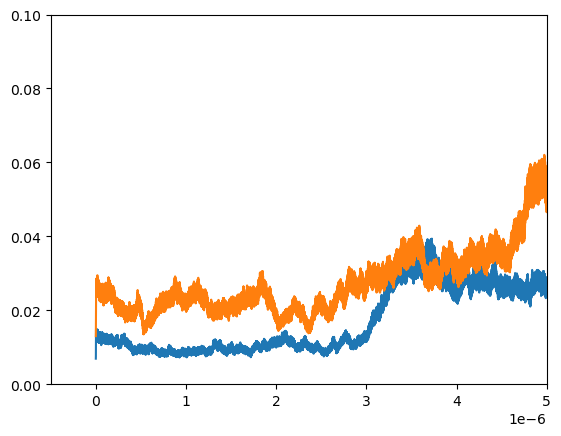

In [91]:
# apply moving average
N = 200
s1 = np.convolve(np.real(i1)*np.sin(w*times), np.ones((N,))/N, mode='same')
s2 = np.convolve(np.real(i2)*np.sin(w*times), np.ones((N,))/N, mode='same')
plt.plot(times,s1)
plt.plot(times,s2)
plt.xlim(right=5*1e-6)
plt.ylim(0,0.1)

In [ ]:
i1

array([ 0.00000000e+00+0.00000000e+00j,  1.04154370e-04-5.01136435e-07j,
        4.16542987e-04-3.50747919e-06j, ...,
       -5.63747058e+01-1.24540984e+01j, -5.65485868e+01-1.16391306e+01j,
       -5.67106870e+01-1.08217380e+01j])

In [ ]:
print(np.max(i1))
print(np.max(i2))

(66.6299852421323-0.010008862837423749j)
(88.71438928986478+0.28518944386785705j)


In [ ]:

def next_OU_step(x, tc, sig, dt):
    n = np.random.normal(0,1)
    return x*(np.exp(-dt/tc)) + +np.sqrt(1-np.exp(-2*dt/tc))*sig*n

def OU_process(x0, tau, sig, tc, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = next_OU_step(x[i-1], tau, sig, tc)
    return x

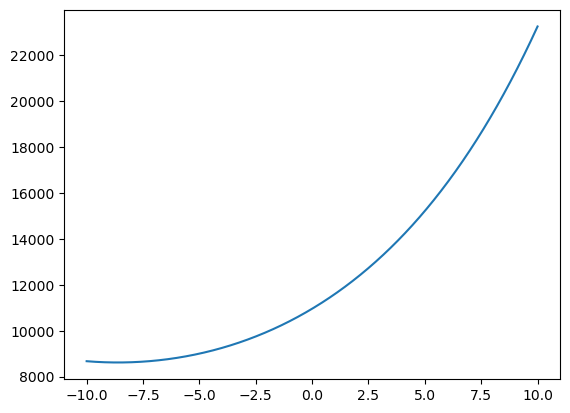

In [ ]:
sd = sensor_dot(gmax=1e-6, T=100, dE = 1e3)

eps = np.linspace(-10,1e1,1001)

plt.plot(eps, sd.get_R(eps))

In [109]:
def RLC_solution(L, C, sd, times, noise, A=1,bit=1):
    w = np.sqrt(1/L/C)
    deps0 = 1
    dt = times[1]-times[0]
    eps = bit*deps0 + np.array([noise.update(dt) for k in range(len(times))]) 
    R = sd.get_R(eps)
    d = np.arctan((1/w/C-w*L)/R)
    return A/np.sqrt((w*L-1/w/C)**2+R**2)*np.sin(w*times+d)



(1e-06, 9e-06)

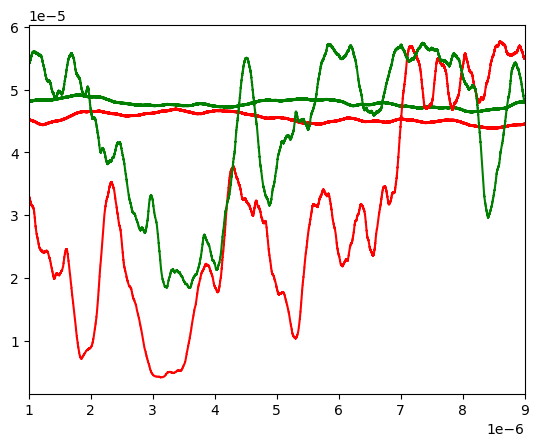

In [115]:
times = np.linspace(0,1e-5,10001)
# apply moving average
OU = OU_process(sig = 1e0, tc =1e-5)
i1 = RLC_solution(Lc, Cp, sd, times, OU, A=1, bit=1)
i2 = RLC_solution(Lc, Cp, sd, times, OU, A=1, bit=-1)
s1 = np.convolve(np.real(i1)*np.sin(w*times), np.ones((N,))/N, mode='same')
s2 = np.convolve(np.real(i2)*np.sin(w*times), np.ones((N,))/N, mode='same')
plt.plot(times,s1, label ="no noise", color="r")
plt.plot(times,s2, label ="no noise", color="g")


OU = OU_process(sig = 1e1, tc =1e-6)
i1 = RLC_solution(Lc, Cp, sd, times, OU, A=1, bit=1)
i2 = RLC_solution(Lc, Cp, sd, times, OU, A=1, bit=-1)
s1 = np.convolve(np.real(i1)*np.sin(w*times), np.ones((N,))/N, mode='same')
s2 = np.convolve(np.real(i2)*np.sin(w*times), np.ones((N,))/N, mode='same')
plt.plot(times,s1, label ="noisy",color="r")
plt.plot(times,s2, label ="noisy",color="g")
plt.xlim(1e-6,9*1e-6)
